# Modeling

In [41]:
import os
import sys
import warnings

import joblib
import mlflow
import numpy as np
import plotly.express as px
import polars as pl
import shap
from optuna.integration.mlflow import MLflowCallback
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split

# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

from modeling import evaluate_thresholds, tune_hgbt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
warnings.filterwarnings("ignore")
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("api_anomaly")
mlflow.sklearn.autolog(disable=True)

### Data

In [5]:
eng_datadf = pl.read_parquet('../data/features_clean_data_supervised.parquet')
eng_datadf.sample(3)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,is_anomaly,std_local_source_degrees,avg_global_source_degrees,max_global_dest_degrees,max_global_source_degrees,std_global_source_degrees,min_global_source_degrees,avg_global_dest_degrees,n_connections,min_global_dest_degrees
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,bool,f64,f64,u32,u32,f64,u32,f64,u32,u32
1115,"""d45e80b0-3bb3-30e6-9ab6-5bd39f…",28.316714,0.785714,14.0,23787,"""default""",2.0,1.0,11.0,"""E""","""outlier""",true,0.40452,3032.909091,22416,10404,3310.043518,261,7157.0,11,186
851,"""c8acc277-96bf-3e23-aecd-fa6cec…",0.000123,0.003113,16.71384,119,"""default""",1195.0,961.0,50.0,"""E""","""normal""",false,3.416422,6185.378571,22416,32071,8742.234697,146,6734.242857,140,182
848,"""0cfb5492-861a-3fc6-b1da-86294c…",0.00078,0.011285,15.36,162,"""default""",251.0,225.0,39.0,"""E""","""normal""",false,3.700745,6102.935484,22416,32071,9673.223128,7,6031.903226,124,5


### Modeling Goal

During intial modeling, I observed that when using just the features provided by the dataset from Kaggle, I was able to obtain a nearly perfect ROC AUC score. 

#### **To make this project more challenging, I will only use the engineered features during modeling.**


In [6]:
label = "is_anomaly"
numerical_features = [
    "std_local_source_degrees",
    "avg_global_source_degrees",
    "max_global_dest_degrees",
    "max_global_source_degrees",
    "std_global_source_degrees",
    "min_global_source_degrees",
    "avg_global_dest_degrees",
    "n_connections",
    "min_global_dest_degrees"]

eng_datadf = eng_datadf.filter(pl.col('ip_type') == 'default').select([label] + numerical_features) # 
eng_datadf.sample(3)

is_anomaly,std_local_source_degrees,avg_global_source_degrees,max_global_dest_degrees,max_global_source_degrees,std_global_source_degrees,min_global_source_degrees,avg_global_dest_degrees,n_connections,min_global_dest_degrees
bool,f64,f64,u32,u32,f64,u32,f64,u32,u32
true,3.575893,5946.070968,22416,32071,8866.009109,74,6248.225806,155,86
false,6.642402,6826.555024,22416,32071,9425.943348,90,9002.789474,209,28
false,1.838554,6538.875,22416,32071,9502.162968,403,6706.472222,72,813


In [7]:
X_train, X_test, y_train, y_test = train_test_split(eng_datadf[numerical_features], eng_datadf[label].to_list(), test_size=0.2)

In [8]:
print("Train shape: ", X_train.shape)
print("Test shape::", X_test.shape)

Train shape:  (1233, 9)
Test shape:: (309, 9)


### Baseline
Can this problem be solved without ML?

In [9]:
from sklearn.metrics import f1_score

heuristic_f1_scores = []
possible_values = X_train['n_connections'].sort().unique().to_list()
for v in possible_values:
    heuristic_pred = X_test.select(pl.col('n_connections') <= v).to_pandas()
    heuristic_f1_scores.append(f1_score(y_test, heuristic_pred))

In [10]:
px.line(
    x=possible_values, 
    y=heuristic_f1_scores, 
    labels={
        "x": "Number of Connections Threshold",
        "y": "F1 Score",
    },
    title='F1 Score for Heuristic Rule'
)

##### Insights
 * The optimal number of connections to set as a threshold is 50
 * Heuristic rule achieves an F1 score of 0.78

Let's compare this with an ML model

### Machine Learning
I will be using a Histogram-Based Gradient Boosting model. To account for the imbalanced nature of the dataset, the HGBT will use balanced class weighting.

In [12]:
with mlflow.start_run(run_name='GBT_baseline'):
    params = {
        "learning_rate": 0.1,
        "max_iter": 10,
        "max_leaf_nodes": 10,
        "max_depth": None,
        "l2_regularization": 0,
        "class_weight": 'balanced'
    }

    mlflow.set_tag("model_name", "HGBT")
    mlflow.log_params(params)

    gbt = HistGradientBoostingClassifier(**params)
    gbt.fit(X_train, y_train)
    
    roc_auc = cross_val_score(gbt, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print('ROC AUC (avg 5-fold):', roc_auc)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(gbt, "gbt_models", input_example=X_train.to_numpy())

ROC AUC (avg 5-fold): 0.9715536628864093


##### Observations
 * The ROC AUC achieved by the initial model is very high (0.97)
##### Insights
 * This could indicate the task being very simple, or target leakage
 * We do not know how the target was created, so we can assume the dataset creators used simple/reliable anomaly detection methods
 * We do not necessarily need to do hyperparameter tuning (0.96 is sufficient for the business use case), but running a few experiments can show how well this model can perform

### Hyperparameter Tuning

In [13]:
mlflc = MLflowCallback(
    tracking_uri="sqlite:///mlflow.db",
    metric_name="roc auc",
)

best_trial = tune_hgbt(20, mlflc, X_train, y_train)

[I 2024-10-14 17:10:08,333] A new study created in memory with name: hgbt_tuning
2024/10/14 17:10:08 INFO mlflow.tracking.fluent: Experiment with name 'hgbt_tuning' does not exist. Creating a new experiment.
[I 2024-10-14 17:10:09,089] Trial 0 finished with value: 0.9880100603621731 and parameters: {'max_iter': 52, 'max_leaf_nodes': 19, 'max_depth': 9, 'l2_regularization': 2.248661955836393}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9880100603621731


[I 2024-10-14 17:10:09,815] Trial 1 finished with value: 0.9856695856959942 and parameters: {'max_iter': 75, 'max_leaf_nodes': 15, 'max_depth': 3, 'l2_regularization': 2.944305228077152}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9856695856959942


[I 2024-10-14 17:10:10,032] Trial 2 finished with value: 0.9597339491494422 and parameters: {'max_iter': 10, 'max_leaf_nodes': 11, 'max_depth': 3, 'l2_regularization': 6.233768670589227}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9597339491494422


[I 2024-10-14 17:10:10,342] Trial 3 finished with value: 0.9606768108651911 and parameters: {'max_iter': 42, 'max_leaf_nodes': 22, 'max_depth': 2, 'l2_regularization': 1.7742188577001838}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9606768108651911


[I 2024-10-14 17:10:10,910] Trial 4 finished with value: 0.9852857600146333 and parameters: {'max_iter': 46, 'max_leaf_nodes': 27, 'max_depth': 6, 'l2_regularization': 5.875202114354883}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9852857600146333


[I 2024-10-14 17:10:11,313] Trial 5 finished with value: 0.9773170385952076 and parameters: {'max_iter': 23, 'max_leaf_nodes': 17, 'max_depth': 8, 'l2_regularization': 7.433535832094282}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9773170385952076


[I 2024-10-14 17:10:11,853] Trial 6 finished with value: 0.9849499725626487 and parameters: {'max_iter': 44, 'max_leaf_nodes': 23, 'max_depth': 7, 'l2_regularization': 6.621556763306359}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9849499725626487


[I 2024-10-14 17:10:12,414] Trial 7 finished with value: 0.9867863087616608 and parameters: {'max_iter': 43, 'max_leaf_nodes': 25, 'max_depth': 7, 'l2_regularization': 4.104432176000511}. Best is trial 0 with value: 0.9880100603621731.


ROC AUC (avg 5-fold): 0.9867863087616608


[I 2024-10-14 17:10:13,417] Trial 8 finished with value: 0.9888443844887508 and parameters: {'max_iter': 99, 'max_leaf_nodes': 14, 'max_depth': 9, 'l2_regularization': 8.14695639097796}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9888443844887508


[I 2024-10-14 17:10:14,150] Trial 9 finished with value: 0.988341137735504 and parameters: {'max_iter': 80, 'max_leaf_nodes': 31, 'max_depth': 5, 'l2_regularization': 1.435358561685588}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.988341137735504


[I 2024-10-14 17:10:15,154] Trial 10 finished with value: 0.9876037589171393 and parameters: {'max_iter': 99, 'max_leaf_nodes': 10, 'max_depth': 10, 'l2_regularization': 9.517064051345985}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9876037589171393


[I 2024-10-14 17:10:16,102] Trial 11 finished with value: 0.9884134351563929 and parameters: {'max_iter': 96, 'max_leaf_nodes': 30, 'max_depth': 5, 'l2_regularization': 0.14946574799028678}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9884134351563929


[I 2024-10-14 17:10:16,990] Trial 12 finished with value: 0.9879877446497165 and parameters: {'max_iter': 100, 'max_leaf_nodes': 14, 'max_depth': 5, 'l2_regularization': 0.11523246110150609}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9879877446497165


[I 2024-10-14 17:10:18,549] Trial 13 finished with value: 0.987400219498811 and parameters: {'max_iter': 78, 'max_leaf_nodes': 31, 'max_depth': 10, 'l2_regularization': 8.984829400299677}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.987400219498811


[I 2024-10-14 17:10:19,400] Trial 14 finished with value: 0.9879058441558441 and parameters: {'max_iter': 89, 'max_leaf_nodes': 27, 'max_depth': 5, 'l2_regularization': 4.323419727461712}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9879058441558441


[I 2024-10-14 17:10:20,704] Trial 15 finished with value: 0.9863720504847265 and parameters: {'max_iter': 63, 'max_leaf_nodes': 19, 'max_depth': 8, 'l2_regularization': 8.13696135829712}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9863720504847265


[I 2024-10-14 17:10:21,685] Trial 16 finished with value: 0.9881170660325589 and parameters: {'max_iter': 89, 'max_leaf_nodes': 14, 'max_depth': 4, 'l2_regularization': 0.024785240837085137}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9881170660325589


[I 2024-10-14 17:10:22,508] Trial 17 finished with value: 0.9869982165721602 and parameters: {'max_iter': 65, 'max_leaf_nodes': 29, 'max_depth': 6, 'l2_regularization': 4.807235017275725}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9869982165721602


[I 2024-10-14 17:10:23,756] Trial 18 finished with value: 0.9878810133528443 and parameters: {'max_iter': 92, 'max_leaf_nodes': 21, 'max_depth': 9, 'l2_regularization': 8.521564712838783}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9878810133528443


[I 2024-10-14 17:10:24,462] Trial 19 finished with value: 0.9873200567038595 and parameters: {'max_iter': 67, 'max_leaf_nodes': 12, 'max_depth': 7, 'l2_regularization': 3.040288391468902}. Best is trial 8 with value: 0.9888443844887508.


ROC AUC (avg 5-fold): 0.9873200567038595


In [14]:
print(best_trial.params)

{'max_iter': 99, 'max_leaf_nodes': 14, 'max_depth': 9, 'l2_regularization': 8.14695639097796}


### Final Model

In [15]:
best_gbt = HistGradientBoostingClassifier(**best_trial.params)
best_gbt.fit(X_train, y_train)
test_preds = best_gbt.predict_proba(X_test)

print('Test ROC AUC:', roc_auc_score(y_test, test_preds[:, 1]))
print('Test PR AUC:', average_precision_score(y_test, test_preds[:, 1]))

Test ROC AUC: 0.9886107231116363
Test PR AUC: 0.974492746495239


In [40]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds[:, 1])

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, test_preds[:, 1])

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(recall, precision):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

##### Observations
 * The ROC AUC is about 0.015 higher with the best model

### Threshold Analysis & Evaluation

In [25]:
thresholds = np.arange(0, 1.01, 0.01)

rcs, prs, f1s = evaluate_thresholds(thresholds, y_test, test_preds, plot=True)

Threshold with Max F1 Score:  0.33
F1 at threshold 0.33: 0.926829268292683
Recall at threshold 0.33: 0.926829268292683
Precision at threshold 0.33: 0.926829268292683 


##### Observations
$$
\text{Precision} = \frac{TP}{TP + FP}
$$
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

 * From the plot, notice that when threshold is at 0.33, all 3 lines converge. This could mean that at this threshold, the **number of false positives is equal to the number of false negatives** (derived from the mathematical formulas for f1, precision, and recall above)
##### Impact
 * We will investigate the actual number of FP and TP at this threshold later in the notebook

### Model Diagnostics

##### Feature Importances

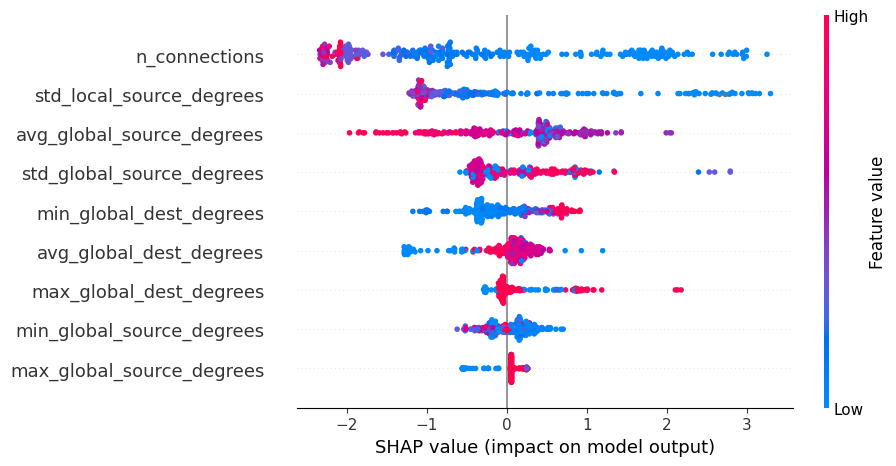

In [17]:
explainer = shap.Explainer(best_gbt)
shap_values = explainer(X_test[numerical_features].to_pandas())
shap.plots.beeswarm(shap_values)

##### Observations
 * having a low number of connections is a strong indicator of anomalous behavior

##### False Positives & False Negatives

In [29]:
thr = 0.33
test_binary_pred = test_preds[:, 1] >= thr

fps = np.where((np.array(y_test) == False) & (test_binary_pred == True))[0]
fns = np.where((np.array(y_test) == True) & (test_binary_pred == False))[0]

print(f"There are {len(fps)} false positives")
print(f"There are {len(fns)} false negatives")

There are 6 false positives
There are 6 false negatives


##### Observations
 * as mentioned previously, at the threshold that maximizes f1 score, we see that there are an equal number of FP and FN (6 false positives and 6 false negatives)

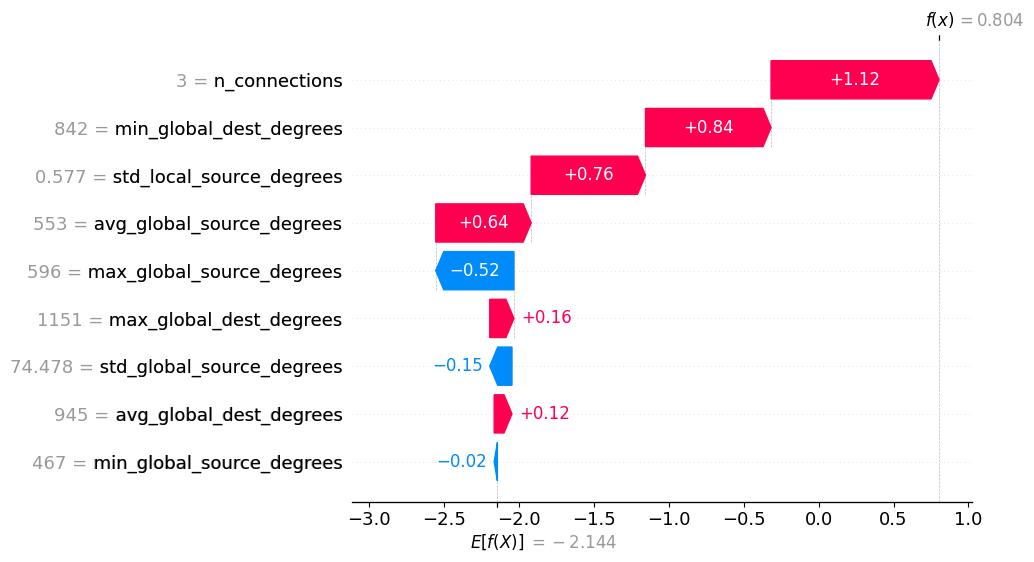

In [30]:
shap.plots.waterfall(shap_values[fps[0]])

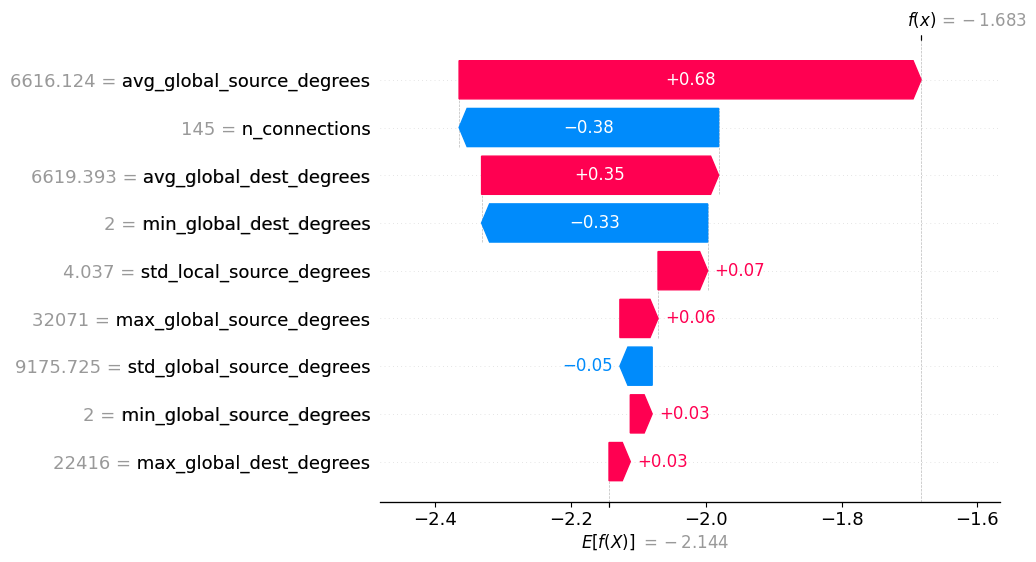

In [31]:
shap.plots.waterfall(shap_values[fns[0]])

##### Observations
 * The examples of false positives and false negatives above show that number of connections has a strong influence on the classification of an example

### Dump Model for Deployment

In [24]:
joblib.dump(best_gbt, '../model/best_hgbt.joblib')

['../model/best_hgbt.joblib']

### Summary
 * The modeling task for anomaly detection is solved fairly easily by training supervised ML model
 * To make the task more challenging, only the engineered features were used for anomaly detection
 * The optimal model trained is HistGBT with threshold of 0.33
 * The maximum F1 that can be achieved with the trained model is 0.927, which also gives us a recall of 0.927 and precision 0.927
 * The trained model outperforms the heuristic baseline by ~0.15 in terms of F1 score
 * SHAP values suggest that smaller networks tend to be more anomalous